In [1]:
import torch, dgl

import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
from collections import defaultdict

from mordred import Calculator, descriptors
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem
RDLogger.DisableLog('rdApp.*')

from dgl.data.utils import save_graphs

from feature import *
from utils import load_obj, calculate_pair_distance

# Data load

In [2]:
train = pd.read_csv('/home/sim/project/metabolic-stability/data/CMMS-GCL/train.csv')
test  = pd.read_csv('/home/sim/project/metabolic-stability/data/CMMS-GCL/test.csv')

In [48]:
def smiles_to_mol( smiles ):
    mol = Chem.MolFromSmiles( smiles )
    AllChem.AddHs(mol)
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
        
    return mol

In [51]:
# train_mols = { idx: smiles_to_mol(smiles) for idx, (value, smiles) in tqdm( enumerate( zip( train['Label'], train['SMILES'] ) ) )}
test_mols  = { idx: smiles_to_mol(smiles) for idx, (value, smiles) in tqdm( enumerate( zip( test['Label'],  test['SMILES'] ) ) ) }

111it [00:01, 62.62it/s]


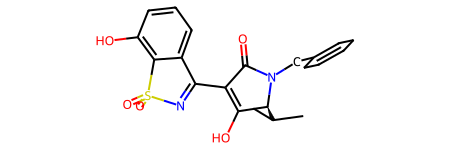

In [56]:
mol = test_mols[100]
mol

In [57]:
for mol in test_mols.values():
    for atom in mol.GetAtoms():
        print(atom.GetChiralTag())
        # break
    break

CHI_UNSPECIFIED
CHI_UNSPECIFIED
CHI_UNSPECIFIED
CHI_UNSPECIFIED
CHI_UNSPECIFIED
CHI_UNSPECIFIED
CHI_UNSPECIFIED
CHI_UNSPECIFIED
CHI_UNSPECIFIED
CHI_UNSPECIFIED
CHI_TETRAHEDRAL_CCW
CHI_UNSPECIFIED
CHI_TETRAHEDRAL_CW
CHI_UNSPECIFIED
CHI_UNSPECIFIED
CHI_UNSPECIFIED
CHI_UNSPECIFIED
CHI_UNSPECIFIED
CHI_UNSPECIFIED
CHI_UNSPECIFIED
CHI_UNSPECIFIED
CHI_UNSPECIFIED
CHI_UNSPECIFIED
CHI_UNSPECIFIED


# Mordred descriptor

In [12]:
calc = Calculator(descriptors, ignore_3D=True)
train_mordred = calc.pandas(train_mols.values())
test_mordred  = calc.pandas(test_mols.values())

 25%|█████████▉                              | 737/2970 [01:18<03:41, 10.10it/s]

/home/sim/anaconda3/envs/MSP/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 32%|████████████▉                           | 961/2970 [01:38<03:32,  9.44it/s]

/home/sim/anaconda3/envs/MSP/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 33%|█████████████                           | 968/2970 [01:39<03:44,  8.90it/s]

/home/sim/anaconda3/envs/MSP/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 39%|███████████████                        | 1148/2970 [01:55<04:43,  6.42it/s]

/home/sim/anaconda3/envs/MSP/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 41%|███████████████▊                       | 1206/2970 [02:00<02:33, 11.52it/s]

/home/sim/anaconda3/envs/MSP/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 49%|███████████████████▏                   | 1459/2970 [02:21<02:32,  9.89it/s]

/home/sim/anaconda3/envs/MSP/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 51%|████████████████████                   | 1527/2970 [02:27<01:21, 17.80it/s]

/home/sim/anaconda3/envs/MSP/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 87%|█████████████████████████████████▉     | 2581/2970 [04:34<00:45,  8.63it/s]

/home/sim/anaconda3/envs/MSP/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|███████████████████████████████████████████| 61/61 [00:05<00:00, 11.69it/s]


In [13]:
mordred = pd.concat( [train_mordred, test_mordred] ).astype(float).dropna(axis=1)

In [16]:
# train_mordred = mordred.iloc[:3498, :]
# test_mordred  = mordred.iloc[3498:, :]

In [14]:
max  = train_mordred.max()
mean = train_mordred.mean()
std  = train_mordred.std()

TypeError: '>=' not supported between instances of 'Error' and 'Error'

In [ ]:
max

In [10]:
train_mordred = (train_mordred - mean) / std
test_mordred  = (test_mordred - mean) / std

# Finger Print

In [5]:
radius = 2
nBits = 1024

morgan = [ AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits) for mol in train_mols.values() ]
train_morgan = pd.DataFrame( [ list(l) for l in morgan ] )

morgan = [ AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits) for mol in test1_mols.values() ]
test1_morgan = pd.DataFrame( [ list(l) for l in morgan ] )

morgan = [ AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits) for mol in test2_mols.values() ]
test2_morgan = pd.DataFrame( [ list(l) for l in morgan ] )

morgan = [ AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits) for mol in test3_mols.values() ]
test3_morgan = pd.DataFrame( [ list(l) for l in morgan ] )

# Graph

In [4]:
def mol_to_graph( mol ):
    n    = mol.GetNumAtoms()
    h    = get_atom_feature(mol)
    adj  = get_bond_feature(mol).to_sparse(sparse_dim=2)
    vn_h = torch.mean( h, dim=0 ).unsqueeze(0)

    h = torch.cat( (h, vn_h), dim=0 )

    u = adj.indices()[0]
    v = adj.indices()[1]
    e = adj.values()
    
    ve = torch.tensor( [ (n, i) for i in range(n) ] + [ (i, n) for i in range(n) ] )
    
    ve_u = ve[:, 0]
    ve_v = ve[:, 1]
        
    u = torch.cat( (u, ve_u) )
    v = torch.cat( (v, ve_v) )

    num_ve = ve.shape[0]
    e_dim  = e.shape[1]
    ve_e = torch.zeros( (num_ve, e_dim) )

    e = torch.cat( (e, ve_e), dim=0 )
    
    g = dgl.DGLGraph()
    g.add_nodes( n + 1 )
    g.add_edges( u, v )

    g.ndata['feats'] = h
    g.edata['feats'] = e

    return g

In [9]:
train_morgan_tensor  = torch.tensor( train_morgan.values ).float()
test1_morgan_tensor  = torch.tensor( test1_morgan.values ).float()
test2_morgan_tensor  = torch.tensor( test2_morgan.values ).float()
test3_morgan_tensor  = torch.tensor( test3_morgan.values ).float()

In [18]:
# for idx, (name, mol) in tqdm( enumerate( train_mols.items() ) ):
#     graph_labels = { "label": torch.tensor( [train_label[idx]] ).float(), "g_morgan": train_morgan_tensor[idx] }

#     try:
#         g = mol_to_graph(mol)
#         save_graphs( f'../data/train/{g_name}.bin', g, graph_labels )
        
#     except Exception as E:        
#         print(E, name)

for idx, (name, mol) in tqdm( enumerate( test1_mols.items() ) ):
    graph_labels = { "label": torch.tensor( [test1_label[idx]] ).float(), "g_morgan": test1_morgan_tensor[idx] }

    try:
        g = mol_to_graph(mol)
        save_graphs( f'../data/test1/{idx}.bin', g, graph_labels )
        
    except Exception as E:        
        print(E, name)

for idx, (name, mol) in tqdm( enumerate( test2_mols.items() ) ):
    graph_labels = { "label": torch.tensor( [test2_label[idx]] ).float(), "g_morgan": test2_morgan_tensor[idx] }

    try:
        g = mol_to_graph(mol)
        save_graphs( f'../data/test2/{idx}.bin', g, graph_labels )
        
    except Exception as E:        
        print(E, name)

for idx, (name, mol) in tqdm( enumerate( test3_mols.items() ) ):
    graph_labels = { "label": torch.tensor( [test3_label[idx]] ).float(), "g_morgan": test3_morgan_tensor[idx] }

    try:
        g = mol_to_graph(mol)
        save_graphs( f'../data/test3/{idx}.bin', g, graph_labels )
        
    except Exception as E:        
        print(E, name)

100it [00:00, 169.72it/s]
9it [00:00, 202.80it/s]
61it [00:00, 289.77it/s]


In [10]:
arontier_smi = open( "/home/sim/project/MP/_PAST/MSP/DACON/data/arontier_junsuha.smi" ).readlines()
arontier_mols = {  line.split('\t')[1].strip() : Chem.MolFromSmiles( line.split('\t')[0] ) for line in arontier_smi}
arontier_mols

for idx, (name, mol) in tqdm( enumerate( arontier_mols.items() ) ):
    graph_labels = { "label": torch.tensor( [0] ).float(), "g_morgan": torch.tensor( [0] ).float() }


    try:
        g = mol_to_graph(mol)
        save_graphs( f'../data/arontier/{name}.bin', g, graph_labels )
        
    except Exception as E:        
        print(E, name)

91it [00:00, 216.05it/s]


In [5]:
arontier_smi = open( "/home/sim/project/MP/_PAST/MSP/Graph/data/0_best.tsv" ).readlines()
arontier_mols = {  line.split('\t')[1].strip() : Chem.MolFromSmiles( line.split('\t')[0] ) for line in arontier_smi}
arontier_mols

for idx, (name, mol) in tqdm( enumerate( arontier_mols.items() ) ):
    graph_labels = { "label": torch.tensor( [0] ).float(), "g_morgan": torch.tensor( [0] ).float() }


    try:
        g = mol_to_graph(mol)
        save_graphs( f'../data/arontier_0308/{name}.bin', g, graph_labels )
        
    except Exception as E:        
        print(E, name)

0it [00:00, ?it/s]/home/sim/anaconda3/envs/MSP/lib/python3.8/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(
3it [00:00, 28.55it/s]

'NoneType' object has no attribute 'GetNumAtoms' index


133it [00:00, 164.10it/s]
